In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import segmentation
from skimage.measure import label, regionprops, regionprops_table, shannon_entropy
import os
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics,svm

#Class and functions used

##Functions

In [2]:
def display_img(image,title='Image',x_label=None,y_label=None,cmap_type='gray',show_axis=False,colorBar=False,F_size=(8,6)):
  plt.figure(figsize=F_size)
  plt.imshow(image,cmap=cmap_type)
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  if colorBar: plt.colorbar()
  if not show_axis: plt.axis('off')
  plt.show()

def count_0_1(array):

  count1,count0 = 0,0

  for element in array:

    if element == 1:
      count1+=1
    else:
      count0+=1
  
  return count0,count1

def generate_knn_model(train_data,label_train_data,test_data):
    knn = KNeighborsClassifier()
    knn.fit(train_data,label_train_data)
    predicted = knn.predict(test_data)
    return predicted

def generate_naive_bayes_model(train_data,label_train_data,test_data):
    gnb = GaussianNB()
    gnb.fit(train_data, label_train_data)
    predicted = gnb.predict(test_data)
    return predicted

def generate_svm_model(train_data,label_train_data,test_data):
    clf = svm.SVC(kernel='linear')
    clf.fit(train_data, label_train_data)
    predicted = clf.predict(test_data)
    return predicted

def generate_MLP_model(X_train, y_train,test_data):
    classifier = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=300,activation = 'relu',solver='adam',random_state=1)
    classifier.fit(X_train, y_train)
    predicted = classifier.predict(test_data)
    return predicted


##Classes

In [3]:
class classification:

  def __init__(self,x_train, x_test, y_train, y_test):
    
    self.x_train, self.x_test, self.y_train, self.y_test = x_train, x_test, y_train, y_test
  
  def extraction(self):

    x = [self.x_train,self.x_test]
    image_props = {'training':[],'test':[]}
    group_names = ['training','test']

    for index,group in enumerate(x):

      for image in group:

        #thresh = threshold_otsu(image)
        #binary = np.array(image > thresh).astype(int)
        #white_pixel = np.where(binary > 0)
        #if len(white_pixel[0]) > 7000:
          #binary = abs(1-binary) # ajuste de imagens negativas
        regions = regionprops(image)
        contour_area , contour_perimeter, contour_convex_area, diameter = self.get_contours_param(regions)
        image_props[group_names[index]].append([contour_area , contour_perimeter, contour_convex_area, diameter,shannon_entropy(image,base=2)])
    
    return image_props

  def get_contours_param(self,contour):
    contour_area = contour[0].filled_area
    contour_perimeter = contour[0].perimeter
    contour_convex_area = contour[0].convex_area
    diameter = contour[0].equivalent_diameter
    self.features_extracted = ['area','perimeter','convex_area','diameter','shannon_entropy']
    return contour_area , contour_perimeter, contour_convex_area, diameter



#Loading dataset

Number of cropped maligno images: 262
Number of cropped benigno images: 275
(44, 44) (44, 44) (44, 44) (44, 44)


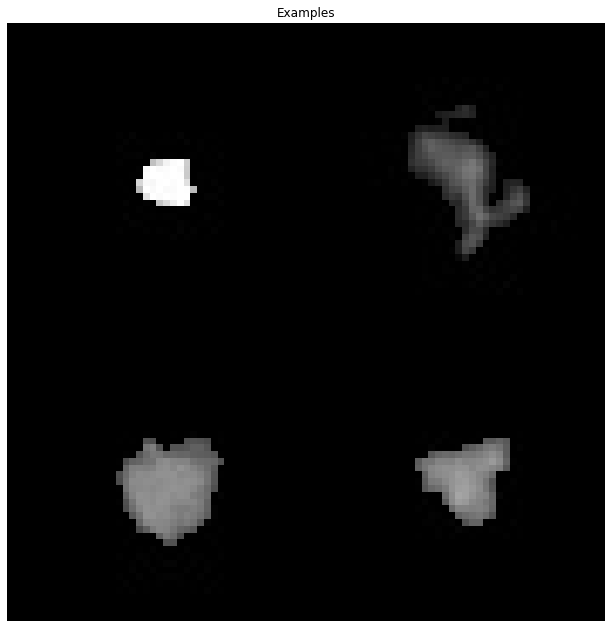

In [4]:
select_images_randomly = False

#Get images from google drive
directory_path_malignos = '/content/drive/MyDrive/cropped_and_treated_nods_maligno/'
directory_path_benignos = '/content/drive/MyDrive/cropped_and_treated_nods_benigno/'

directory_files = os.listdir(directory_path_malignos)
array_of_images_malignos = [plt.imread( os.path.join(directory_path_malignos,file) ) for file in directory_files]

directory_files = os.listdir(directory_path_benignos)
array_of_images_benignos = [plt.imread( os.path.join(directory_path_benignos,file) ) for file in directory_files]

print(f'Number of cropped maligno images: {len(array_of_images_malignos)}')
print(f'Number of cropped benigno images: {len(array_of_images_benignos)}')

#Select 4 images to display as example bellow

index_benigno1,index_benigno2 = 2,3
index_maligno1,index_maligno2 = 10,16
[benigno1,benigno2] = [array_of_images_benignos[index_benigno1],array_of_images_benignos[index_benigno2]]
[maligno1,maligno2] = [array_of_images_malignos[index_maligno1],array_of_images_malignos[index_maligno2]]

print(benigno1.shape,benigno2.shape,maligno1.shape,maligno2.shape)

four_images = np.vstack([  np.hstack([benigno1, benigno2]),  np.hstack([maligno1, maligno2])  ])
display_img(four_images,title='Examples',F_size=(11,11))

tumor_picture = four_images

##Splitting data into training and test set

The x and y arrays are composed of images. The features will be extracted in the next section.

In [5]:
x = [*array_of_images_malignos,*array_of_images_benignos]
y = [*[1 for _ in array_of_images_malignos],*[0 for _ in array_of_images_benignos]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42,shuffle=True)

print(f'Size of training set {len(y_train)}')
count0,count1=count_0_1(y_train)
print(f'class 0 size: {count0} class 1 size: {count1}. ratio: {count1/(count0+count1)}')
print(f'Size of test set {len(y_test)}')
count0,count1=count_0_1(y_test)
print(f'class 0 size: {count0} class 1 size: {count1}. ratio: {count1/(count0+count1)}')

Size of training set 359
class 0 size: 186 class 1 size: 173. ratio: 0.4818941504178273
Size of test set 178
class 0 size: 89 class 1 size: 89. ratio: 0.5


#Obtaining features

The extrated features were area, perimeter, convex area, diameter and shannon entropy.



In [8]:
model = classification(x_train, x_test, y_train, y_test)
result = model.extraction()
print('training set')
df = pd.DataFrame(result['training'],columns = model.features_extracted )
display(df)
print('test set')
df = pd.DataFrame(result['test'],columns = model.features_extracted )
display(df)
print(len(y_train))

training set


,area,perimeter,convex_area,diameter,shannon_entropy
0,69,13.071068,931,9.373021,4.579922
1,106,41.970563,1104,11.617375,2.865700
2,127,54.662951,1240,12.716187,3.667023
3,52,12.278175,402,8.136858,0.997402
4,43,12.656854,507,7.399277,1.088901
...,...,...,...,...,...
354,87,24.142136,1356,10.524820,4.505950
355,106,32.798990,1364,11.617375,4.377845
356,83,28.520815,1084,10.280023,4.724718
357,217,125.604076,1521,16.622063,3.471375


test set


,area,perimeter,convex_area,diameter,shannon_entropy
0,12,2.414214,50,3.908820,0.169761
1,146,46.248737,1693,13.634257,4.648292
2,41,18.692388,231,7.225152,0.561735
3,77,24.727922,1180,9.901487,4.579556
4,33,10.035534,246,6.482045,0.693618
...,...,...,...,...,...
173,348,222.746212,1902,21.049640,2.509595
174,179,123.704581,1230,15.096684,1.637707
175,70,24.727922,541,9.440697,3.085016
176,26,14.071068,114,5.753627,0.277540


359


#Classification

## setting up the hyperparameters

In [7]:
result_knn = generate_knn_model(result['training'],y_train,result['test'])
result_naive = generate_naive_bayes_model(result['training'],y_train,result['test'])
result_svm = generate_svm_model(result['training'],y_train,result['test'])
result_mlp = generate_MLP_model(result['training'],y_train,result['test'])

all_results = [result_knn,result_naive,result_svm,result_mlp]

result_metrics = []

for result_per_model in all_results:

  accuracy = metrics.accuracy_score(result_per_model,y_test)
  recall = metrics.recall_score(result_per_model,y_test)
  precision = metrics.precision_score(result_per_model,y_test)

  result_metrics.append([accuracy,recall,precision])

result_df = pd.DataFrame(result_metrics,columns = ['accuracy','recall','precision'],index = ['knn','naive','svm','mlp'])
display(result_df)

,accuracy,recall,precision
knn,0.691011,0.693182,0.685393
naive,0.662921,0.617886,0.853933
svm,0.741573,0.779221,0.674157
mlp,0.741573,0.674797,0.932584
